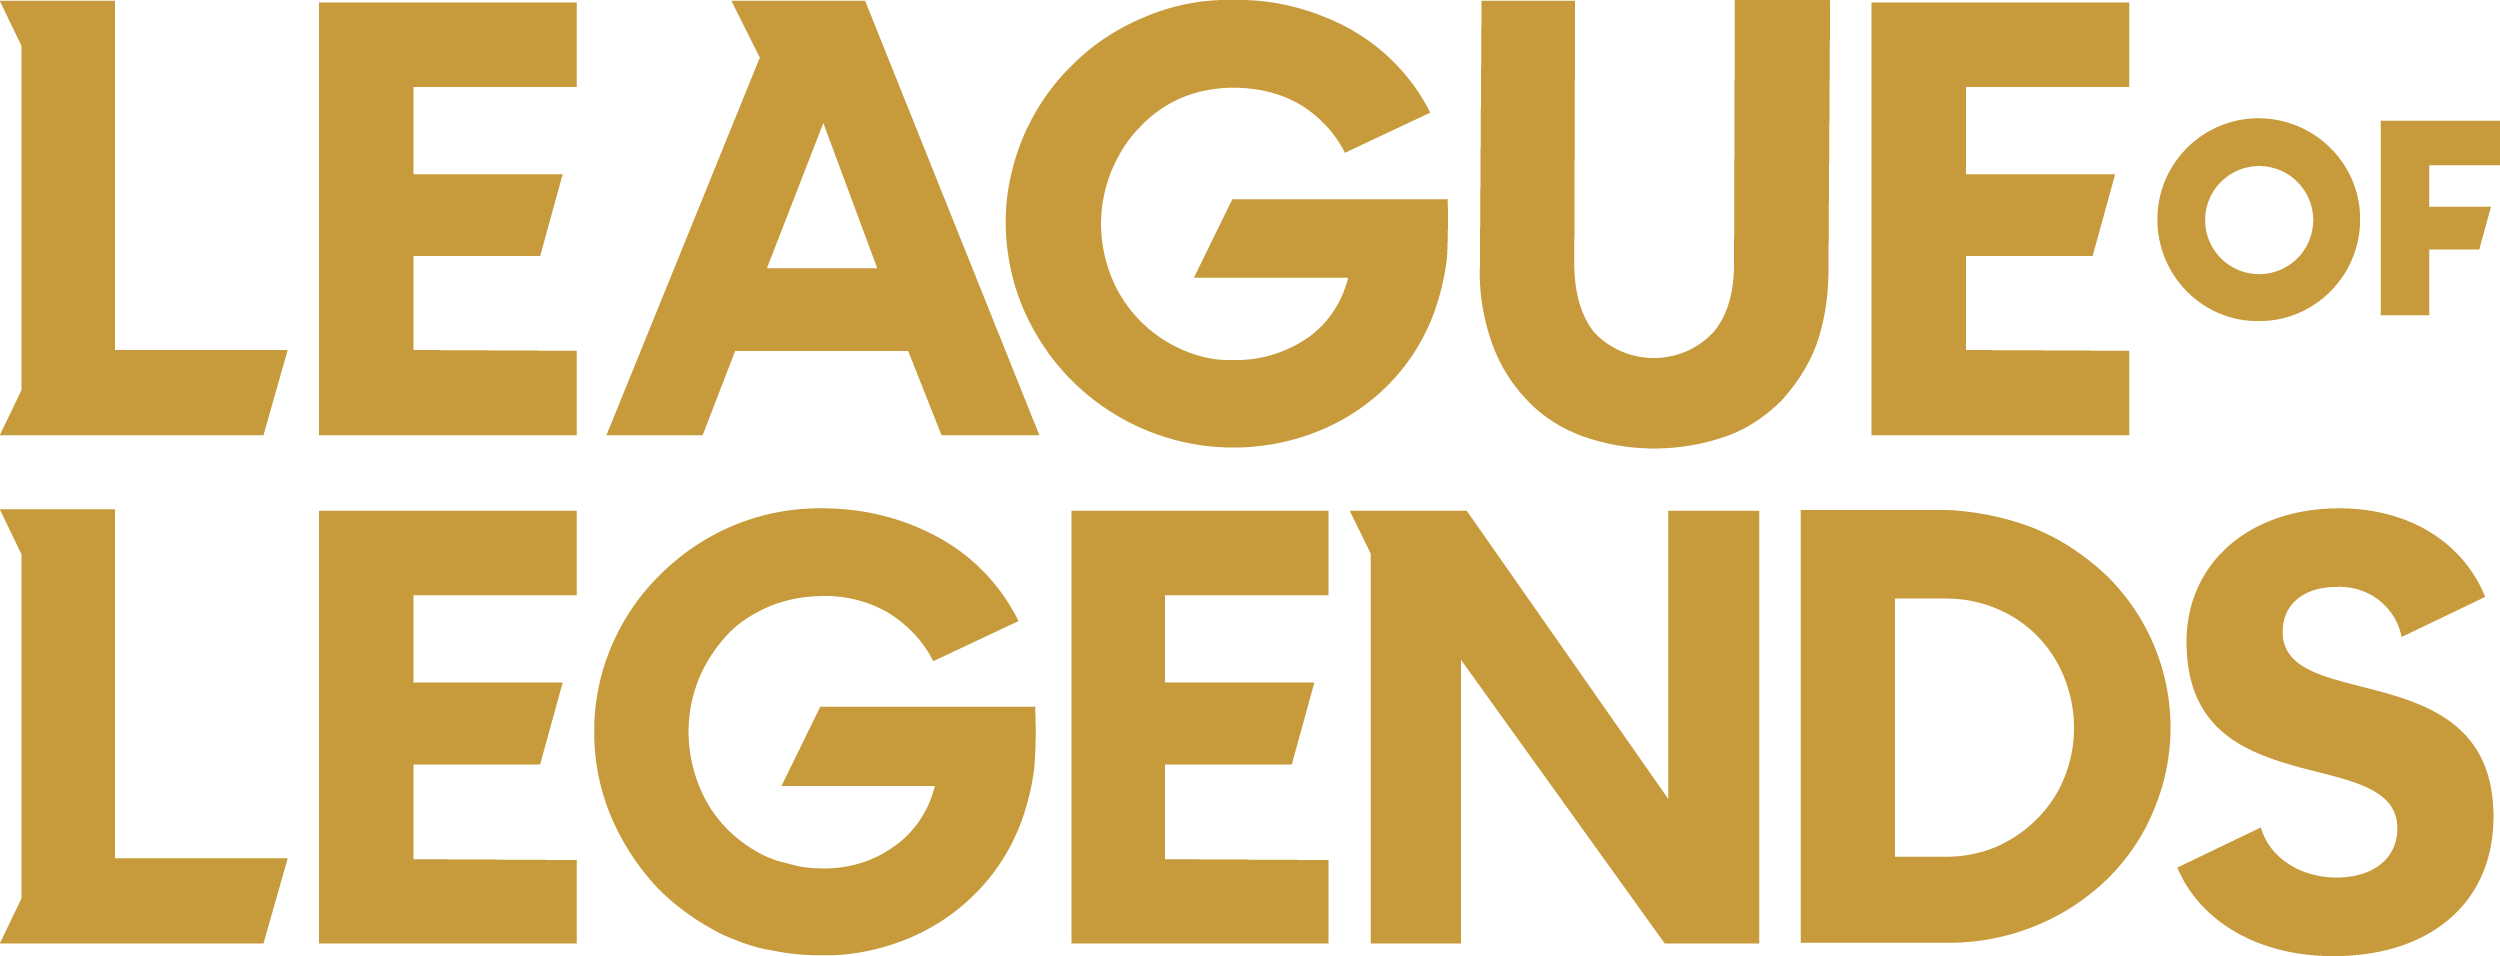

In [53]:
from IPython.display import Image
Image('data/League_of_Legends_2019_vector.png')

# Introduction
league of legends is a competitive MOBA game, where two teams
composed of 5 player's each have to win by destroying the enemy nexus "base".

in the game each player has to "kill minions/monsters/players" in order to get
gold with would result in a game advantage with would make it easier for the team to win.

# Data
This project uses 10-minutes of data collected from over twenty-six-thousand unique league of legends games.

the games were collected from high-elo player games, a.k.a. the top 0.01% players in the game.<br>
the data contains stats like gold per team,
kills, dragon kills, tower destroyed, minion killed and so on...
<br> and of course who won at the end.
- note : usually the games take on average 26+ minutes, with game's rarely ending before
the 15-minute mark, thus we can reasonably assume that anything can happen after the 10-minute mark.

# Purpose
the purpose of this project is to build a machine learning model that can predict as accurately
as possible which team would win the match. based on the stats at the end first 10 minutes of each match.

our assumption is that the biggest lead a.k.a. team with most kill's, gold, dragons etc...
would most likely win, and we will test that assumption.

### Import required Libraries

In [98]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

## data overview

In [63]:
league = pd.read_csv('data/league_f10min_data.csv')
pd.set_option('display.max_columns', None)
league.head()

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragnoType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,4247263043,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,[],0,0,0,0,0,0,[],0,0,1,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,4247155821,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,[],0,0,0,0,0,0,[],0,1,0,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,[],0,0,0,0,0,0,[],0,0
2,4243963257,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,[],0,0,0,0,0,0,[],0,0,1,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,4241678498,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,[],0,0,0,0,0,0,[],0,0,1,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,[],0,0,0,0,0,0,[],0,0
4,4241538868,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,[],0,0,0,0,0,0,[],0,1,0,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,[],0,0,0,0,0,0,[],0,0


#### we can see a summary of the data by using info.

In [56]:
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26409 entries, 0 to 26408
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gameId                      26409 non-null  int64  
 1   blueWins                    26409 non-null  int64  
 2   blueTotalGolds              26409 non-null  int64  
 3   blueCurrentGolds            26409 non-null  int64  
 4   blueTotalLevel              26409 non-null  int64  
 5   blueAvgLevel                26409 non-null  float64
 6   blueTotalMinionKills        26409 non-null  int64  
 7   blueTotalJungleMinionKills  26409 non-null  int64  
 8   blueFirstBlood              26409 non-null  int64  
 9   blueKill                    26409 non-null  int64  
 10  blueDeath                   26409 non-null  int64  
 11  blueAssist                  26409 non-null  int64  
 12  blueWardPlaced              26409 non-null  int64  
 13  blueWardKills               264

#### it seems there is no null values but let's run the following line to be sure.

In [57]:
league.isna().values.any()

False

# cleanup

#### next lets remove any duplicate game's so first lets see if there are any duplicates

In [58]:
number_of_unique = len(league["gameId"].unique())
number_of_entries = league.shape[0]
print("number of entries:", number_of_entries, "number of unique entries:", number_of_unique)

number of entries: 26409 number of unique entries: 26354


#### we can see that there is some duplicate games, so lets remove those duplicates

In [59]:
league = league.drop_duplicates('gameId', keep='first').reindex()
print("number of entries:", league.shape[0], "number of unique entries:", len(league["gameId"].unique()))

number of entries: 26354 number of unique entries: 26354


#### Removing columns we dont need
- gameId clearly that column doesn't affect the game outcome.
- redWins if blue didn't win that means red won, hence we can remove that too.
<br>we will rename blueWins to winner.
- remove DragnoType and FirstTowerLane as they are not numbers and cause problems for now.
the data from those columns also present in other columns expect we do not know the specific type
with i assume would not affect the outcome much.

In [128]:
league_data = league.drop(["gameId", "redWins"], axis=1).rename(columns={"blueWins": "Winner"})
league_data = league_data.drop(["redDragnoType", "blueDragnoType", "blueFirstTowerLane", "redFirstTowerLane"], axis=1)
league_data

,Winner,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragon,blueRiftHeralds,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragon,redRiftHeralds
0,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,0,0,0,0,0,0,0,0,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,0,0,0,0,0,1,1,0
1,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,0,0,0,0,0,0,0,1,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,0,0,0,0,0,0,0,0
2,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,0,0,0,0,0,0,0,0,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,1,0,0,1,0,1,1,1
3,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,0,0,0,0,0,0,0,0,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,0,0,0,0,0,0,0,0
4,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,0,0,0,0,0,0,0,1,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,0,16762,5072,36,7.2,206,52,0,7,5,9,21,4,0,0,0,0,0,0,0,0,0,0,14779,3709,36,7.2,205,67,0,5,7,1,18,4,0,0,0,0,0,0,0,1,1,1
26405,0,35765,1440,39,7.8,191,16,0,18,27,17,23,0,1,0,2,0,2,0,0,1,1,0,42001,9568,44,8.8,279,73,0,27,18,20,22,0,0,0,3,1,0,2,0,0,0,0
26406,0,15712,4137,34,6.8,218,55,0,3,0,4,17,8,0,0,0,0,0,0,0,0,0,0,14845,1345,34,6.8,239,60,0,0,3,0,43,3,0,0,0,0,0,0,0,0,0,0
26407,1,15850,3220,33,6.6,193,48,0,6,4,14,17,6,0,0,0,0,0,0,0,1,1,0,14773,3673,33,6.6,204,52,0,4,6,8,16,4,0,0,0,0,0,0,0,0,0,0


### First try
- #### first lets see what is the percentage of blue wins.

In [75]:
blue_percent = league_data.loc[league_data["Winner"] == 1].shape[0]
print("blue won at", blue_percent/league_data.shape[0] ," of the matches")

blue won at 0.5011170434321632  of the matches


#### hence, out dummy classifier would accurately predict about 50.011% of the games if we just always say blue wins.
- #### let's try to use the data as is, and see what is the initial accuracy.

In [327]:
train_set, test_set = train_test_split(league_data, test_size = 0.2, random_state = 2)
# print( train_set.shape)
# print( test_set.shape)

def split_test_train(data_set):
    return data_set.drop('Winner', axis = 1), data_set['Winner']

x_train, y_train = split_test_train(train_set)
x_test, y_test = split_test_train(test_set)

In [329]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)

reg = LogisticRegression(max_iter = 1000)
x_train_copy = scaler.transform(x_train) # I want to avoid changing the original
scores = cross_val_score(reg, x_train_copy, y_train, scoring = 'accuracy', cv = 10)

print(scores.mean())

0.7425560921567783


In [330]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

reg.fit(x_train_copy, y_train)

X_test_copy = scaler.transform(x_test)
preds = reg.predict(X_test_copy)
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = preds).ravel()

acc = (tn + tp)/(tn + fp + fn + tp)

print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 73.29%


#### we get about 74.25% accuracy, which is not bad at all considering we only changed the data a little bit.

### next step lets transform the data in hopes of improving the score even more.
- first lets see the correlation between features and winning.
- secondly lets remove all the columns that have only one unique value, if there any.

In [142]:
def remove_non_unique(data_set : pd.DataFrame):
    drop = []
    for column in data_set.columns:
        if len(data_set[column].unique()) == 1:
            drop.append(column)
    print("dropped",drop)
    return data_set.drop(drop, axis=1)
league_data_modified = remove_non_unique(league_data)

dropped ['blueFirstBlood', 'redFirstBlood']


In [245]:
corr_mat = league_data_modified.corr()
corr_mat['Winner']

Winner                        1.000000
blueTotalGolds                0.140417
blueCurrentGolds              0.154432
blueTotalLevel                0.126903
blueAvgLevel                  0.126903
blueTotalMinionKills          0.139105
blueTotalJungleMinionKills    0.070855
blueKill                      0.211745
blueDeath                    -0.194815
blueAssist                    0.135611
blueWardPlaced                0.021860
blueWardKills                 0.055029
blueFirstTower                0.124908
blueFirstInhibitor            0.062192
blueTowerKills                0.113607
blueMidTowerKills             0.089914
blueTopTowerKills             0.060394
blueBotTowerKills             0.075792
blueInhibitor                 0.061521
blueFirstDragon               0.203402
blueDragon                    0.203213
blueRiftHeralds               0.103563
redTotalGolds                -0.125431
redCurrentGolds              -0.157622
redTotalLevel                -0.100251
redAvgLevel              

### next correlation
- we will discard columns that are highly correlated for instance redDeath == blueKills and so on
<br> for that we will discard columns with over 0.95 correlation,( of course excluding the win )

In [246]:
def remove_correlated(data_set : pd.DataFrame, percent : float, ignore : str):
    corr_m = data_set.corr()
    drop = []
    for look in data_set.columns:
        if look == ignore or look in drop:
            continue
        for at in data_set.columns:
            if look == at or at == ignore:
                continue
            if abs(corr_m[look][at]) > percent:
                print(look, at, abs(corr_m[look][at]))
                drop.append(at)
    print("dropped highly correlated:", drop)
    return data_set.drop(drop, axis=1)


league_data_modified2 = remove_correlated(league_data_modified, 0.95, "Winner")

blueTotalLevel blueAvgLevel 1.0000000000000073
blueKill redDeath 1.0
blueDeath redKill 1.0
blueFirstInhibitor blueInhibitor 0.996927565224206
blueFirstDragon blueDragon 0.993109537103956
redTotalLevel redAvgLevel 0.9999999999999993
redFirstInhibitor redInhibitor 0.9976634554961813
redFirstDragon redDragon 0.9947320326991433
dropped highly correlated: ['blueAvgLevel', 'redDeath', 'redKill', 'blueInhibitor', 'blueDragon', 'redAvgLevel', 'redInhibitor', 'redDragon']


### combining the data
- a lot of rows are just opposite, so we can in fact combine them,
for instance we can create GoldDiff = redGold - blueGold etc...
- for the last step we will drop any columns with correlation higher than 80%.

so lets do exactly that.

In [325]:
def combine_data(data_set : pd.DataFrame, pre1 : str, pre2 : str, ignore):
    data_new = data_set.copy()
    drop = []
    for column in data_set.columns:
        if column.startswith(pre2) or not column.startswith(pre1):
            continue
        if column in ignore:
            continue
        label = column[len(pre1):]
        column_other = pre2 + label
        if column_other not in data_set.columns:
            continue
        data_new[column] -= data_new[column_other]
        data_new = data_new.rename(columns={column: label + "_diff"})
        drop.append(column_other)
    return data_new.drop(drop, axis=1)
league_data_modified3 = combine_data(league_data_modified2, "blue", "red", ["Winner"])
league_data_modified3 = remove_correlated(league_data_modified3, 0.8, "Winner")
league_data_modified3

TotalGolds_diff TotalLevel_diff 0.8520858403135755
dropped highly correlated: ['TotalLevel_diff']


,Winner,TotalGolds_diff,CurrentGolds_diff,TotalMinionKills_diff,TotalJungleMinionKills_diff,blueKill,blueDeath,Assist_diff,WardPlaced_diff,WardKills_diff,FirstTower_diff,FirstInhibitor_diff,TowerKills_diff,MidTowerKills_diff,TopTowerKills_diff,BotTowerKills_diff,FirstDragon_diff,RiftHeralds_diff
0,0,-3527,-408,-30,21,3,9,-15,2,-6,0,0,0,0,0,0,-1,0
1,1,-1396,-2161,-5,-13,2,3,0,2,-4,0,0,0,0,0,0,0,1
2,0,-4792,-2567,-13,-6,3,11,-7,-6,2,-1,0,-1,0,0,-1,-1,-1
3,0,-466,-2194,-5,16,3,4,-3,50,-3,0,0,0,0,0,0,0,0
4,1,1884,189,63,-10,7,5,-1,-3,3,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,0,1983,1363,1,-15,7,5,8,3,0,0,0,0,0,0,0,-1,-1
26405,0,-6236,-8128,-88,-57,18,27,-3,1,0,1,0,-1,-1,2,-2,1,0
26406,0,867,2792,-21,-5,3,0,4,-26,5,0,0,0,0,0,0,0,0
26407,1,1077,-453,-11,-4,6,4,6,1,2,0,0,0,0,0,0,1,0


In [321]:
corr_mat = league_data_modified3.corr()
corr_mat['Winner']

Winner                         1.000000
TotalGolds_diff                0.514316
CurrentGolds_diff              0.228151
TotalMinionKills_diff          0.340615
TotalJungleMinionKills_diff    0.184368
Assist_diff                    0.368205
WardPlaced_diff                0.043324
WardKills_diff                 0.094834
FirstTower_diff                0.159443
FirstInhibitor_diff            0.088037
MidTowerKills_diff             0.128166
TopTowerKills_diff             0.083506
BotTowerKills_diff             0.116535
FirstDragon_diff               0.235966
RiftHeralds_diff               0.133227
KD_ratio_diff                  0.480026
Name: Winner, dtype: float64

## observations
some interesting things we can already see in the data, is that of course the team with the most gold
at the 10 minutes mark wins more often.

the second observation with is more intresting is that
Assist_diff is much more important then kills or deaths.

#### looks good lets test our initial model


In [322]:
train_set, test_set = train_test_split(league_data_modified3, test_size = 0.2, random_state = 2)

x_train, y_train = split_test_train(train_set)
x_test, y_test = split_test_train(test_set)

scaler = preprocessing.StandardScaler().fit(x_train)

reg = LogisticRegression(max_iter = 1000)
x_train_copy = scaler.transform(x_train) # I want to avoid changing the original
scores = cross_val_score(reg, x_train_copy, y_train, scoring = 'accuracy', cv = 10)

print(scores.mean())

0.7437394905634672


#### we can see a slight improvement, yet we reduced the number of features quite a bit.

In [323]:
reg.fit(x_train_copy, y_train)

X_test_copy = scaler.transform(x_test)
preds = reg.predict(X_test_copy)
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = preds).ravel()

acc = (tn + tp)/(tn + fp + fn + tp)

print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 73.99%


we made things a little bit worse but we cut down the number of features by almost 60% so its a small price to pay.

### lets plot out confusion matrix

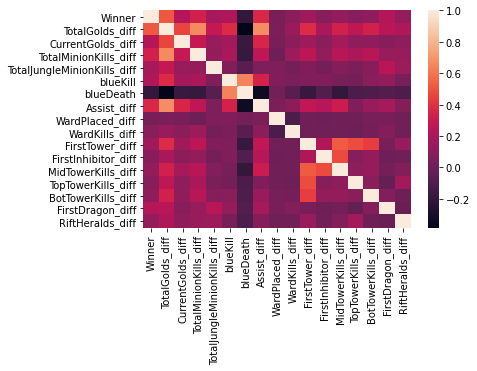

In [247]:
corrMatrix = league_data_modified3.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()